# Tagliamento analysis
---

This notebook contains the analysis of the relationship between the morphological active width (MAW) and the t/Txnr ratio at the Pinzano site along the Tagliamento river. Some other relationships with the exner timescale are investigated.
The methodology is as follow:
1. Estimate relationship between water discharge, depth and sediment flux from cross-sections and uniform flow model
1. Import the water depth measurements from the Venzone station
2. Average the water depth every hour
3. Calculate Q from the water depth and Qs, Wetted width, Water depth, Txnr, t/Txnr and dimensionless streamm power w* every hour.
4. Detecting flood from the water discharge time serie based on a critical discharge Qc (Q>Qc are considered floods)
5. Import survey time period and for each compute the mean_Q_above_Qc, max_Q_above_Qc, mean_Ww_above_Qc, max_Ww_above_Qc, sum_t_Txnr_above_Qc, mean_w*_above_Qc, max_w*_above_Qc.
6. Compute DoDs envelops
7. Compute the MAW as follow:
$$
\frac{Area\; of\; morphological\; changes}{Reach\; length\; *\; Max\; wetted\; width}
$$ for the survey time period.

In [5]:
import os
import rasterio 
import numpy as np
import pandas as pd
import math
from osgeo import gdal
from osgeo import osr
import matplotlib.pyplot as plt

In [6]:
home_folder = os.getcwd()

In [7]:
# functions
# Function to read the tif file and return the 2D array
def read_tif(file_path):
    """
    Reads the first band of a GeoTIFF file and retrieves its no-data value.

    Parameters:
    - file_path (str): Path to the GeoTIFF file.

    Returns:
    - array (ndarray): 2D NumPy array containing the raster data.
    - no_data_value (float/int/None): No-data value for the raster (or None if not set).
    """
    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the first band
        no_data_value = src.nodata  # Retrieve the no-data value (if set)
    return array, no_data_value


GDAL_DATA_TYPE = gdal.GDT_Float32 
GEOTIFF_DRIVER_NAME = r'GTiff'
def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):
    ''' returns gdal data source raster object

    '''
    # create driver
    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path,
                                  int(columns),
                                  int(rows),
                                  nband,
                                  eType = gdal_data_type)    
    return output_raster


def numpy_array_to_raster(output_path,
                          numpy_array,
                          upper_left_tuple,
                          cell_resolution_x,  # Resolution in x-direction
                          cell_resolution_y,  # Resolution in y-direction
                          no_data=0,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=4326,  # Default to WGS84
                          driver='GTiff'):
    ''' Returns a GDAL raster data source from a 2D or 3D NumPy array.

    Keyword arguments:
    - output_path -- Full path to the raster to be written to disk.
    - numpy_array -- NumPy array containing data to write to raster.
                     2D array for single-band, 3D array for multi-band.
    - upper_left_tuple -- Upper left point of the numpy array (structured as (x, y)).
    - cell_resolution_x -- The cell resolution of the output raster in x-direction.
    - cell_resolution_y -- The cell resolution of the output raster in y-direction.
    - no_data -- Value in numpy array that should be treated as no data.
    - gdal_data_type -- GDAL data type of raster (see GDAL documentation for list of values).
    - spatial_reference_system_wkid -- Well Known ID (WKID) of the spatial reference system.
    - driver -- String value of the GDAL driver to use (e.g., 'GTiff' for GeoTIFF).

    Returns:
    - output_raster -- The created GDAL raster object.
    '''

    # Check if the input numpy array is 2D or 3D
    if len(numpy_array.shape) == 2:  # Single-band image
        rows, columns = numpy_array.shape
        bands = 1
    elif len(numpy_array.shape) == 3:  # Multi-band image
        rows, columns, bands = numpy_array.shape
    else:
        raise ValueError("Unsupported array shape: should be 2D (single-band) or 3D (multi-band).")

    print(f'Array Shape: Rows = {rows}, Columns = {columns}, Bands = {bands}')

    # Create the output raster with the specified driver
    gdal_driver = gdal.GetDriverByName(driver)
    output_raster = gdal_driver.Create(output_path, columns, rows, bands, gdal_data_type)

    if output_raster is None:
        raise Exception(f"Failed to create raster: {output_path}")

    # Set geotransform (upper-left corner, pixel resolution in x and y, and other parameters)
    geotransform = (upper_left_tuple[0],  # x-coordinate of the upper-left corner
                    cell_resolution_x,    # pixel width (x-resolution)
                    0,                    # rotation (0 if image is north-up)
                    upper_left_tuple[1],  # y-coordinate of the upper-left corner
                    0,                    # rotation (0 if image is north-up)
                    -cell_resolution_y)   # pixel height (y-resolution, negative for north-up)

    output_raster.SetGeoTransform(geotransform)

    # Define the spatial reference system
    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromEPSG(spatial_reference_system_wkid)
    output_raster.SetProjection(spatial_reference.ExportToWkt())

    # Write each band (for multi-band images, or just one band for single-band)
    for band in range(bands):
        output_band = output_raster.GetRasterBand(band + 1)  # Bands are 1-based in GDAL
        output_band.SetNoDataValue(float(no_data))
        if bands == 1:
            # Single-band raster
            output_band.WriteArray(numpy_array)
        else:
            # Multi-band raster, write each band
            output_band.WriteArray(numpy_array[:, :, band])
        output_band.FlushCache()
        output_band.ComputeStatistics(True)

    # Ensure the file was created
    if not os.path.exists(output_path):
        raise Exception(f'Failed to create raster: {output_path}')
    
    print(f"Raster successfully created at {output_path}")

    return output_raster


# Study sites
---

<img title="a title" alt="Alt text" src="./images/study_sites.png" width="500" height="200">

<img title="a title" alt="Alt text" src="./images/dataset.png" width="600" height="300">

<img title="a title" alt="Alt text" src="./images/dataset_results_resume.png" width="600" height="300">

# Pinzano
---

## Estimate relationship between water discharge, depth and sediment flux

Based on cross-sections and uniform flow model

In [8]:
# See cross_sections.xlsm file (done at Pinzano site with hydraulic model)
# Qs = a*Q**b
a = 1e-6
b = 1.86

# Ww = c*Q**d 
c = 14.5
d = 0.53

# Dw = e*Q+f
e = 0.11 #0.0005
f = 0.32 # 0.47
porosity = 0.20

## Import water discharge dataset

In [9]:
path = os.path.join(home_folder,'pinzano')
df_hydro = pd.read_csv(os.path.join(path,'hydro_data.csv'), delimiter =',') # water_depth over time at Venzone station
df_hydro['data e ora'] = pd.to_datetime(df_hydro['data e ora'], format='%d/%m/%Y %H:%M')

### Average water depth from the Venzone station every hour

In [10]:
# Mean water depth every hour
initial_window_size = 3 #1h
window_size = 3
alternative_window_size = 4 #1h from 2021-06-09 00:00 (time_step= 15 minutes)
condition_value = pd.to_datetime('09/06/2021 00:00', format='%d/%m/%Y %H:%M')

# Create a list to store the rolling mean values
rolling_mean_values = []

# Iterate over the DataFrame
for i in range(len(df_hydro)):
    # Check if condition is met to change the window size
    if df_hydro.loc[i, 'data e ora'] == condition_value:
        window_size = alternative_window_size
    elif df_hydro.loc[i, 'data e ora'] != condition_value and window_size == alternative_window_size:
        window_size = alternative_window_size
    else:
        window_size = initial_window_size
    
    # Calculate rolling mean for the current row
    if i + 1 >= window_size:
        # Get the window of values based on the dynamic window size
        window = df_hydro['water depth [cm]'][i + 1 - window_size:i + 1]
        rolling_mean = window.mean()
    else:
        # Not enough data points for the window, so set NaN
        rolling_mean = np.nan

    # Append the calculated mean to the list
    rolling_mean_values.append(rolling_mean)

# Add the rolling mean values as a new column
df_hydro['water depth hour mean [cm]'] = rolling_mean_values
df_hydro = df_hydro.fillna(0)

In [11]:
df_hydro

,data e ora,water depth [cm],water_depth [m],water depth hour mean [cm]
0,2011-01-01 00:00:00,-5.0,-0.05,0.000000
1,2011-01-01 00:30:00,-6.0,-0.06,0.000000
2,2011-01-01 01:00:00,-6.0,-0.06,-5.666667
3,2011-01-01 01:30:00,-8.0,-0.08,-6.666667
4,2011-01-01 02:00:00,-5.0,-0.05,-6.333333
...,...,...,...,...
307915,2024-12-31 22:45:00,0.0,0.00,0.000000
307916,2024-12-31 23:00:00,0.0,0.00,0.000000
307917,2024-12-31 23:15:00,0.0,0.00,0.000000
307918,2024-12-31 23:30:00,0.0,0.00,0.000000


## Calculate Q, Qs, Ww, Water depth and t/Txnr

In [12]:
# estimate Q
def calculate_Q(row):
    # Access the columns
    depth_cm = row['water depth hour mean [cm]']
    if depth_cm < -44 :
        Q=0
    elif depth_cm == 0:
        Q= 0
    elif depth_cm <120:
        Q = ((depth_cm/100+0.45)/0.029168)**(1/0.6845)
    elif depth_cm < 148:
        Q = (depth_cm/1.89)**1.4225
    else:
        Q = (depth_cm/4.88)**1.818

    Q=np.round(Q,decimals=2)
    
    return Q
    
df_hydro['Q [m3/s]'] = df_hydro.apply(calculate_Q, axis=1)
# estimate Qs
df_hydro['Qs [m3/s]'] = a*df_hydro['Q [m3/s]']**b
# estimate Wetted width
df_hydro['Ww [m]'] = c*df_hydro['Q [m3/s]']**d
df_hydro['Ww [m]'] = df_hydro['Ww [m]'].where(df_hydro['Ww [m]']  <= 570, 570)

# estimate mean water depth
df_hydro['Dmean [m]'] = e*df_hydro['Q [m3/s]']**f
df_hydro['Dmean [m]'] = df_hydro['Dmean [m]'].where(df_hydro['water depth hour mean [cm]']  != 0, 0)
df_hydro['Dmean [m]'] = df_hydro['Dmean [m]'].where(df_hydro['water depth hour mean [cm]']  >= -44, 0)

# Compute t_Txnr
def calculate_t_Txnr(row):
    #porosity = 0.20
    condition = pd.to_datetime('09/06/2021 00:00', format='%d/%m/%Y %H:%M')

    # Access the columns
    depth = row['Dmean [m]']
    wetted_width = row['Ww [m]']
    Q = row['Q [m3/s]']
    Qs = row['Qs [m3/s]']
    date = row['data e ora']
    if date >= condition:
        time_step = 15 #min 2021-06-09 00:00 (time_step= 15 minutes)
    else:
        time_step = 30 #min

    if depth == 0:
        t_txnr = 0
    elif row['data e ora'] <= pd.to_datetime('01/01/2011  00:30' , format='%d/%m/%Y %H:%M'):
        t_txnr = 0
    else:
        t_txnr = (time_step*60)/((1-porosity)*((depth*(wetted_width**2))/Qs))
    
    return t_txnr

def calculate_Txnr(row):
    #porosity = 0.20
    
    # Access the columns
    depth = row['Dmean [m]']
    wetted_width = row['Ww [m]']
    Q = row['Q [m3/s]']
    Qs = row['Qs [m3/s]']
    date = row['data e ora']

    if depth == 0:
        txnr = 0
    elif row['data e ora'] <= pd.to_datetime('01/01/2011  00:30' , format='%d/%m/%Y %H:%M'):
        txnr = 0
    else:
        txnr = ((1-porosity)*((depth*(wetted_width**2))/Qs))/3600 # in hours
    
    return txnr

df_hydro['t_Txnr']= df_hydro.apply(calculate_t_Txnr, axis=1)
df_hydro['Txnr [h]']= df_hydro.apply(calculate_Txnr, axis=1)

# Compute adim stream power
def calculate_adim_stream_power(row):
    # Access the columns
    Q = row['Q [m3/s]']
    wetted_width = row['Ww [m]']
    d50 = 0.028
    slope = 0.003

    if Q== 0:
        adim_w = 0
    else:
        adim_w = (Q*slope)/(wetted_width*math.sqrt(9.81*1.65*d50**3))
    
    return adim_w
    
df_hydro['w*']= df_hydro.apply(calculate_adim_stream_power, axis=1)

In [13]:
df_hydro

,data e ora,water depth [cm],water_depth [m],water depth hour mean [cm],Q [m3/s],Qs [m3/s],Ww [m],Dmean [m],t_Txnr,Txnr [h],w*
0,2011-01-01 00:00:00,-5.0,-0.05,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2011-01-01 00:30:00,-6.0,-0.06,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2011-01-01 01:00:00,-6.0,-0.06,-5.666667,44.73,0.001175,108.688956,0.371180,0.000603,829.141599,0.065497
3,2011-01-01 01:30:00,-8.0,-0.08,-6.666667,43.08,0.001096,106.545257,0.366742,0.000592,844.235951,0.064350
4,2011-01-01 02:00:00,-5.0,-0.05,-6.333333,43.63,0.001122,107.264044,0.368234,0.000596,839.110728,0.064735
...,...,...,...,...,...,...,...,...,...,...,...
307915,2024-12-31 22:45:00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
307916,2024-12-31 23:00:00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
307917,2024-12-31 23:15:00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
307918,2024-12-31 23:30:00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
output_path = os.path.join(path,'df_hydro.csv')
df_hydro.to_csv(output_path, sep=',',index=True)  # Set index=True if you want to save the index as a column

### Dataframe statistics

In [15]:
df_hydro.describe()

,data e ora,water depth [cm],water_depth [m],water depth hour mean [cm],Q [m3/s],Qs [m3/s],Ww [m],Dmean [m],t_Txnr,Txnr [h],w*
count,307920,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000,307920.000000
mean,2019-01-23 02:55:08.604831744,2.138065,0.021386,2.138161,68.456909,0.007320,114.175293,0.357139,0.000513,947.238328,0.067139
min,2011-01-01 00:00:00,-67.000000,-0.670000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-05-24 17:52:30,-23.000000,-0.230000,-23.000000,15.450000,0.000163,61.872847,0.264150,0.000236,549.305923,0.039741
50%,2019-10-14 11:45:00,-1.000000,-0.010000,-1.000000,45.290000,0.001203,109.408039,0.372661,0.000422,731.810890,0.065881
75%,2022-10-22 02:48:45,16.000000,0.160000,16.000000,84.920000,0.003872,152.666340,0.455697,0.000733,1183.842607,0.088527
max,2024-12-31 23:45:00,479.000000,4.790000,446.750000,3683.580000,4.297960,570.000000,1.522647,0.017717,10870.534892,1.028497
std,NaN,36.448200,0.364510,36.395191,112.582965,0.058682,76.248728,0.165907,0.000435,887.688569,0.043364


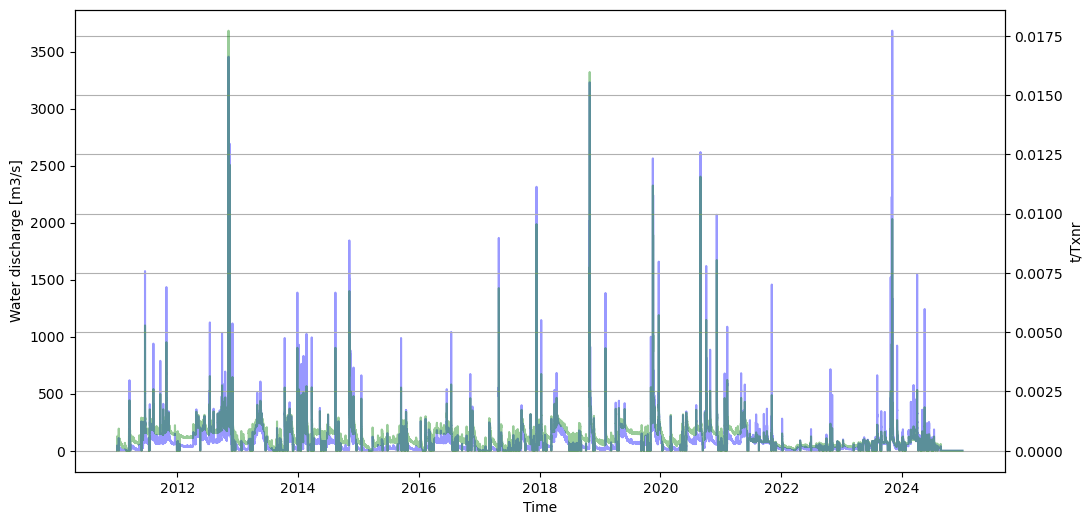

In [16]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['data e ora'], df_hydro['Q [m3/s]'], 'b-', alpha=0.4)
ax1.set_ylabel('Water discharge [m3/s]')
ax1.set_xlabel('Time')
# twinx
ax2 = ax1.twinx()
ax2.plot(df_hydro['data e ora'], df_hydro['t_Txnr'], 'g-', alpha=0.4)
ax2.set_ylabel('t/Txnr')
plt.grid('on')

### Txnr-Q relationship

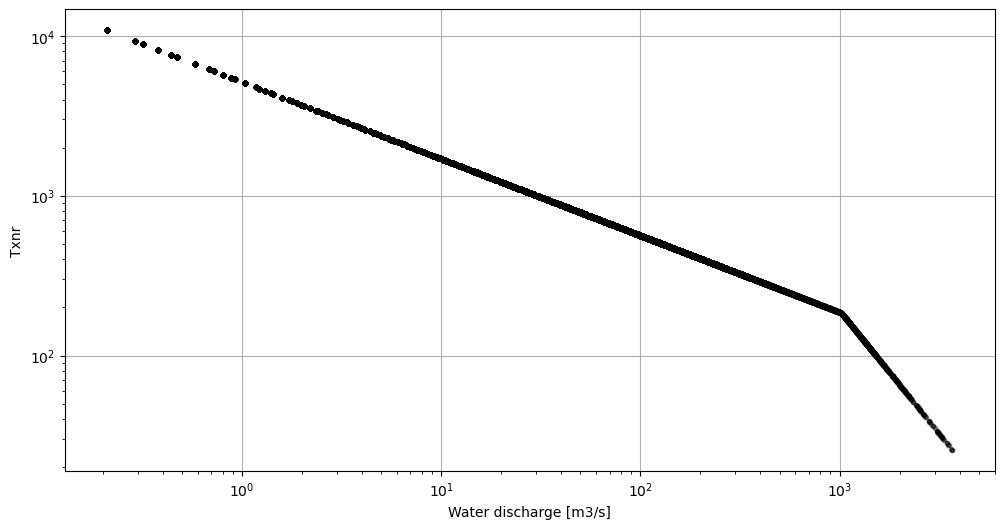

In [17]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['Q [m3/s]'], df_hydro['Txnr [h]'], 'k.', alpha=0.4)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Txnr')
ax1.set_xlabel('Water discharge [m3/s]')
plt.grid('on')

## Estimate Txnr for floods

### Detect floods

Define an id for each period above a critical discharge

In [18]:
# Initialize variables
flood_id = 0
flood_ids = []
# Critical discharge
Qc = 170 # m3/s --> Dmeanc = 0.54 m Hc Venzone = 0.45 m; Venzone hc= 0.65m --> Qc =

# Loop through each row
for i in range(len(df_hydro)):
    if df_hydro.loc[i, 'Q [m3/s]'] > Qc:
        # Start a new flood_id if it's the first in a new block
        if i == 0 or df_hydro.loc[i - 1, 'Q [m3/s]'] <= Qc:
            flood_id += 1
        flood_ids.append(flood_id)
    else:
        flood_ids.append(0)  # Set to 0 when Q <= Qc

# Add the 'flood id' column to the DataFrame
df_hydro['flood id'] = flood_ids

Clean flood id to avoid gaps where Q is close to Qc

In [19]:
# Set the threshold for rows in between
threshold = 40 # =10h

# Get indices of rows where 'flood id' is greater than 0
flood_indices = df_hydro.index[df_hydro['flood id'] > 0].tolist()

# Iterate through each pair of consecutive flood indices
for i in range(len(flood_indices) - 1):
    first_index = flood_indices[i]
    second_index = flood_indices[i + 1]
    
    # Count rows in between
    rows_between = second_index - first_index - 1
    
    # Check if the rows between are below the threshold
    if rows_between < threshold:
        # Update the second 'flood id' to match the first
        df_hydro.at[second_index, 'flood id'] = df_hydro.at[first_index, 'flood id']

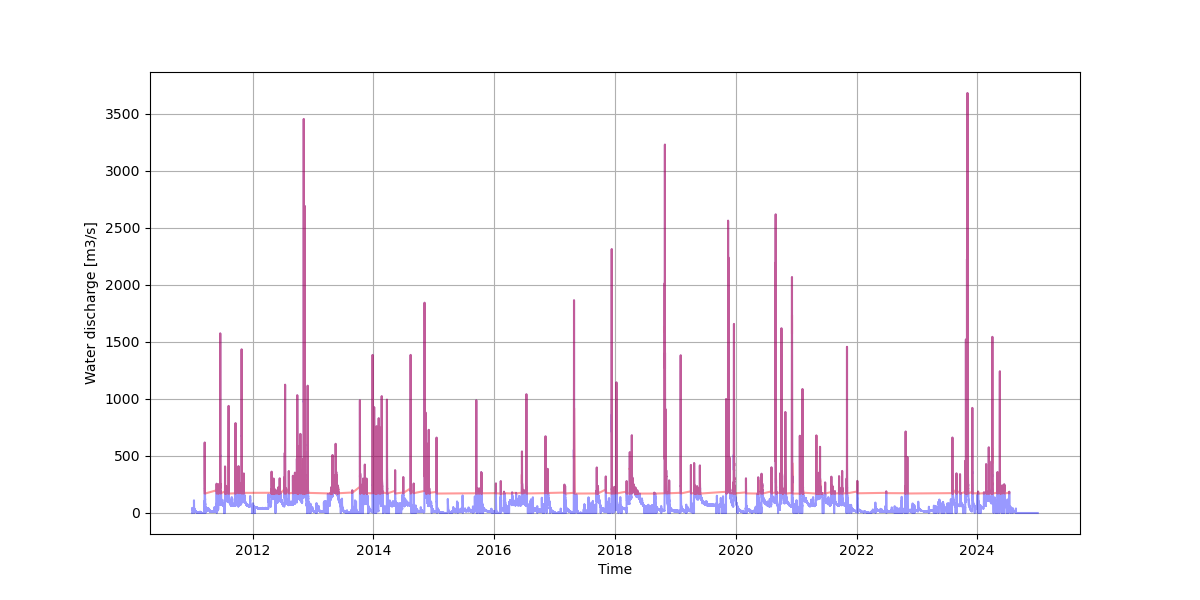

In [20]:
%matplotlib widget

Q_floods = df_hydro.loc[df_hydro['flood id'] > 0, 'Q [m3/s]']
date_floods = df_hydro.loc[df_hydro['flood id'] > 0, 'data e ora']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['data e ora'], df_hydro['Q [m3/s]'], 'b-', alpha=0.4)
ax1.set_ylabel('Water discharge [m3/s]')
ax1.set_xlabel('Time')
ax1.plot(date_floods, Q_floods, 'r-', alpha=0.4)
plt.grid('on')

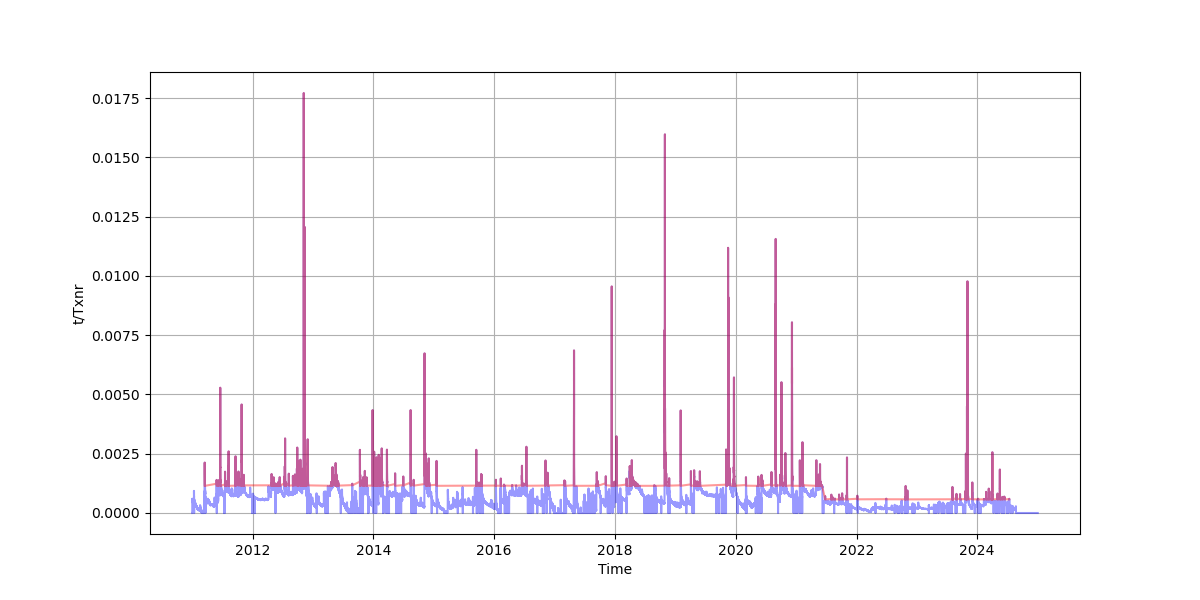

In [21]:
%matplotlib widget
t_Txnr_floods = df_hydro.loc[df_hydro['flood id'] > 0, 't_Txnr']
date_floods = df_hydro.loc[df_hydro['flood id'] > 0, 'data e ora']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(df_hydro['data e ora'], df_hydro['t_Txnr'], 'b-', alpha=0.4)
ax1.set_ylabel('t/Txnr')
ax1.set_xlabel('Time')
ax1.plot(date_floods, t_Txnr_floods, 'r-', alpha=0.4)
plt.grid('on')

### Compute flood statistics

Group by 'flood id' and calculate the sum of 't_Txnr', max and mean of 'Q' for each group

In [22]:
flood_stats = (
    df_hydro[df_hydro['flood id'] > 0]
    .groupby('flood id')
    .agg(t_Txnr_sum=('t_Txnr', 'sum'), max_Q=('Q [m3/s]', 'max'), mean_Q=('Q [m3/s]', 'mean'), duration_days=('data e ora', lambda x: (x.max() - x.min()).total_seconds() / 86400))
    .reset_index()
)
flood_stats

,flood id,t_Txnr_sum,max_Q,mean_Q,duration_days
0,1,0.162192,617.91,310.980926,2.229167
1,2,0.021985,256.51,220.020588,0.333333
2,3,0.050878,252.68,212.642000,1.125000
3,5,0.251304,1575.38,438.371232,3.187500
4,8,0.045481,407.98,241.812353,1.083333
...,...,...,...,...,...
157,391,0.185649,1242.71,352.116186,2.552083
158,393,0.047758,211.05,185.794625,0.822917
159,394,0.062625,242.23,201.192970,1.072917
160,396,0.102852,252.20,208.773988,1.729167


In [23]:
# Filter out flood less than 1 days ( they are no flood)
flood_stats['flood id'] = flood_stats['flood id'].where(flood_stats['duration_days']>1, 0)
flood_stats = flood_stats[flood_stats['flood id']>0]

### Flood duration vs t/Txnr ratio

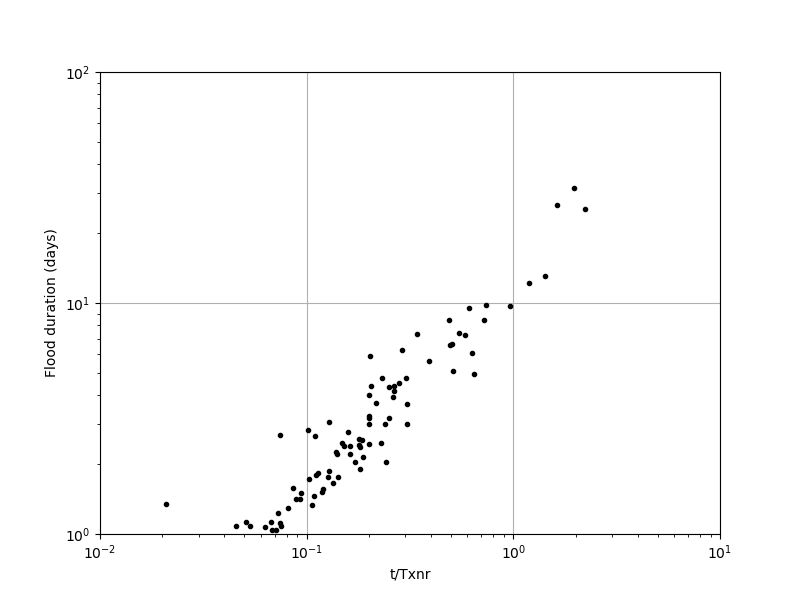

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(flood_stats['t_Txnr_sum'], flood_stats['duration_days'], 'k.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.01,10)
ax1.set_ylim(1,100)
ax1.set_ylabel('Flood duration (days)')
ax1.set_xlabel('t/Txnr')
plt.grid('on')

### Return interval vs t/Txnr ratio

In [25]:
# Define the list of percentiles you want to calculate
percentiles = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.989041095890411,
              0.991780821917808, 0.994520545205479, 0.99726027260274, 0.99863013698628, 0.99908675811033, 0.999452054809031, 0.999789600000000]#, 0.9998630136987793]

# Calculate the specified percentiles for the 'Q' column
percentile_values = df_hydro['Q [m3/s]'].quantile(percentiles).to_numpy()

# Return interval in years
return_interval_year = [np.round(1/(365*(1-p)),decimals=4) for p in percentiles]

In [26]:
# Function to find the closest return interval for each max_Q
def compute_return_interval(max_q):
    return_interval = 0.14215*np.exp(0.001153*max_q)
    return return_interval
def find_return_interval(max_q):
    # Calculate the absolute difference with all values in percentile_values
    differences = np.abs(percentile_values - max_q)
    # Find the index of the smallest difference
    closest_index = np.argmin(differences)
    # Retrieve the corresponding value in 'return_interval_year' using the index
    return return_interval_year[closest_index]

# Apply the function to each 'max_Q' and add the result to the 'return interval' column
flood_stats['return interval'] = flood_stats['max_Q'].apply(compute_return_interval)
flood_stats

C:\Users\enric\AppData\Local\Temp\ipykernel_24188\462209476.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_stats['return interval'] = flood_stats['max_Q'].apply(compute_return_interval)


,flood id,t_Txnr_sum,max_Q,mean_Q,duration_days,return interval
0,1,0.162192,617.91,310.980926,2.229167,0.289841
2,3,0.050878,252.68,212.642000,1.125000,0.190228
3,5,0.251304,1575.38,438.371232,3.187500,0.874188
4,8,0.045481,407.98,241.812353,1.083333,0.227530
6,13,0.053309,237.53,201.395814,1.083333,0.186934
...,...,...,...,...,...,...
155,381,0.547419,1544.83,343.840086,7.447917,0.843932
156,389,0.073894,359.38,255.463832,1.114583,0.215131
157,391,0.185649,1242.71,352.116186,2.552083,0.595694
159,394,0.062625,242.23,201.192970,1.072917,0.187950


In [27]:
df_return_interval = flood_stats[flood_stats['return interval']>0.06]

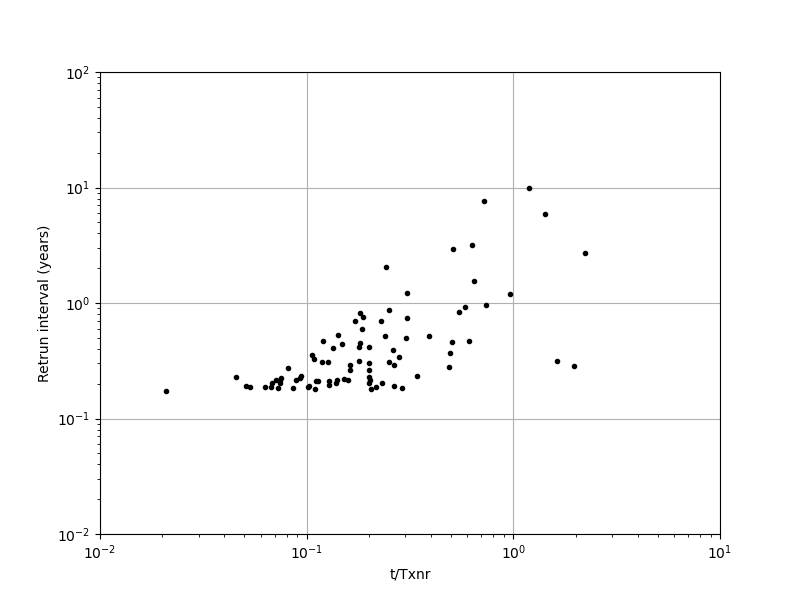

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(df_return_interval['t_Txnr_sum'], df_return_interval['return interval'], 'k.')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.01,10)
ax1.set_ylim(0.01,100)
ax1.set_ylabel('Retrun interval (years)')
ax1.set_xlabel('t/Txnr')
plt.grid('on')

## Import survey time periods and compute variables for each

### Estimate Qmean between two surveys

In [29]:
path = os.path.join(home_folder,'pinzano')
df_surveys = pd.read_csv(os.path.join(path,'survey_dates.csv'), delimiter =',')
df_surveys['Date'] = pd.to_datetime(df_surveys['Date'], format='%d/%m/%Y %H:%M')

In [30]:
df_surveys

,survey_id,Date
0,1,2021-02-17 12:00:00
1,2,2021-09-15 12:00:00
2,3,2022-01-19 12:00:00
3,4,2022-11-29 12:00:00
4,5,2024-06-24 12:00:00
5,5,2021-02-17 12:00:00
6,6,2022-01-19 12:00:00
7,7,2021-09-15 12:00:00
8,8,2022-11-29 12:00:00
9,9,2022-01-19 12:00:00


In [31]:
# Create an empty list to store the results
mean_Ww_values = []
max_Ww_values = []
mean_Q_values = []
max_Q_values = []
sum_t_Txnr_values = []
mean_adim_stream_values = []
max_adim_stream_values = []
# Loop through each pair of consecutive dates in df_surveys
for i in range(len(df_surveys) - 1):
    if i == 0:
        mean_Q_values.append(np.nan) 
        mean_Ww_values.append(np.nan)
        max_Q_values.append(np.nan) 
        max_Ww_values.append(np.nan) 
        sum_t_Txnr_values.append(np.nan)
        mean_adim_stream_values.append(np.nan)
        max_adim_stream_values.append(np.nan)
        
    start_date = df_surveys.loc[i, 'Date']
    end_date = df_surveys.loc[i + 1, 'Date']
    
    # Filter df_hydro to get Ww values between start_date and end_date and Q>Qc
    Q_values_in_range = df_hydro[(df_hydro['data e ora'] >= start_date) & (df_hydro['data e ora'] < end_date)]['Q [m3/s]']
    Ww_values_in_range = df_hydro[(df_hydro['data e ora'] >= start_date) & (df_hydro['data e ora'] < end_date)]['Ww [m]']
    flood_id_in_range = df_hydro[(df_hydro['data e ora'] >= start_date) & (df_hydro['data e ora'] < end_date)]['flood id']
    
    
    # Filter df_hydro to get t_Txnr values between start_date and end_date
    t_Txnr_values_in_range = df_hydro[(df_hydro['data e ora'] >= start_date) & (df_hydro['data e ora'] < end_date)]['t_Txnr']

    # Filter df_hydro to get w* values between start_date and end_date
    adim_stream_values_in_range = df_hydro[(df_hydro['data e ora'] >= start_date) & (df_hydro['data e ora'] < end_date)]['w*']

    Ww_values_in_range = Ww_values_in_range[flood_id_in_range>0]
    t_Txnr_values_in_range = t_Txnr_values_in_range[flood_id_in_range>0]
    if i == 0:
        print(len(t_Txnr_values_in_range))
    adim_stream_values_in_range = adim_stream_values_in_range[flood_id_in_range>0]
    Q_values_in_range = Q_values_in_range[flood_id_in_range>0]
    
    # Compute the mean Q value and append to the list
    mean_Q = Q_values_in_range.mean()
    max_Q = Q_values_in_range.max()
    mean_Q_values.append(mean_Q)
    max_Q_values.append(max_Q)
    
    # Compute the mean Ww value and append to the list
    mean_Ww = Ww_values_in_range.mean()
    max_Ww = Ww_values_in_range.max()
    mean_Ww_values.append(mean_Ww)
    max_Ww_values.append(max_Ww)

    # Compute the mean Ww value and append to the list
    mean_adim_stream = adim_stream_values_in_range.mean()
    max_adim_stream  = adim_stream_values_in_range.max()
    mean_adim_stream_values.append(mean_adim_stream)
    max_adim_stream_values.append(max_adim_stream)

    # Compute the sum t_Txnr value and append to the list
    sum_t_Txnr = t_Txnr_values_in_range.sum()
    sum_t_Txnr_values.append(sum_t_Txnr)

# Add the computed mean Q values to df_surveys as a new column, aligning with the starting date of each range
df_surveys['mean_Q_above_Qc [m]'] = pd.Series(mean_Q_values)
df_surveys['max_Q_above_Qc [m]'] = pd.Series(max_Q_values)
df_surveys['mean_Ww_above_Qc [m]'] = pd.Series(mean_Ww_values)
df_surveys['max_Ww_above_Qc [m]'] = pd.Series(max_Ww_values)
df_surveys['sum_t_Txnr_above_Qc'] = pd.Series(sum_t_Txnr_values)
df_surveys['mean_w*_above_Qc [m]'] = pd.Series(mean_adim_stream_values)
df_surveys['max_w*_above_Qc [m]'] = pd.Series(max_adim_stream_values)

835


In [32]:
df_surveys

,survey_id,Date,mean_Q_above_Qc [m],max_Q_above_Qc [m],mean_Ww_above_Qc [m],max_Ww_above_Qc [m],sum_t_Txnr_above_Qc,mean_w*_above_Qc [m],max_w*_above_Qc [m]
0,1,2021-02-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2021-09-15 12:00:00,238.890156,679.66,259.985041,459.708580,1.006150,0.141709,0.235297
2,3,2022-01-19 12:00:00,310.703909,1457.26,288.007844,570.000000,0.445349,0.157498,0.406883
3,4,2022-11-29 12:00:00,319.546438,714.50,300.674623,472.051287,0.120962,0.161037,0.240891
4,5,2024-06-24 12:00:00,361.826588,3683.58,300.420204,570.000000,3.073159,0.169185,1.028497
5,5,2021-02-17 12:00:00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
6,6,2022-01-19 12:00:00,268.800007,1457.26,271.656313,570.000000,1.451498,0.148285,0.406883
7,7,2021-09-15 12:00:00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
8,8,2022-11-29 12:00:00,312.575344,1457.26,290.688643,570.000000,0.566311,0.158247,0.406883
9,9,2022-01-19 12:00:00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


## Compute DoD envelops

In [33]:
cell_resolution_x , cell_resolution_y =1,1
upper_left_tuple = (0,0)

In [34]:
path = os.path.join(home_folder,'pinzano','rasters')
DoD_names = ['feb-sep','sep-jan','jan-nov','nov-jun']
DEMs_names = ['feb','sep','jan','nov','jun']
for i in range(0,len(DEMs_names)):
        filename = f'{DEMs_names[i]}_wbathy.tif'
        DEM, no_data = read_tif(os.path.join(path,filename))
        dy, dx = np.shape(DEM)
        # Create mask
        if i == 0 :
            mask = np.ones((dy, dx))
        
        mask = np.where(DEM==-9999, 0 , mask)
    
for i, DoD_name in enumerate(DoD_names):
    if i<len(DoD_names)-1:
        filename = f'{DoD_name}_DoD.tif'
        filename2 = f'{DoD_names[i+1]}_DoD.tif'
        DoD1,_ = read_tif(os.path.join(path,filename))
        DoD2,_ = read_tif(os.path.join(path,filename2))
        #mask nan values
        DoD1 = np.where(DoD1==-9999,0,DoD1)
        DoD2 = np.where(DoD2==-9999,0, DoD2)
        DoD1_bool = np.where(np.abs(DoD1)>0,1,0)
        DoD2_bool = np.where(np.abs(DoD2)>0,1,0)
        envDoD = DoD1_bool + DoD2_bool
        envDoD = np.where(envDoD>0,1,0)
        output_path = os.path.join(path, filename[0:3]+filename2[3:-8]+'_envDoD.tif')
    else:
        filename = f'{DoD_names[0]}_DoD.tif'
        filename2 = f'{DoD_names[1]}_DoD.tif'
        filename3 = f'{DoD_names[2]}_DoD.tif'
        filename4 = f'{DoD_names[3]}_DoD.tif'
        DoD1,_ = read_tif(os.path.join(path,filename))
        DoD2,_ = read_tif(os.path.join(path,filename2))
        DoD3,_ = read_tif(os.path.join(path,filename3))
        DoD4,_ = read_tif(os.path.join(path,filename4))
        #mask nan values
        DoD1 = np.where(DoD1==-9999,0,DoD1)
        DoD2 = np.where(DoD2==-9999,0, DoD2)
        DoD3 = np.where(DoD3==-9999,0,DoD3)
        DoD4 = np.where(DoD3==-9999,0,DoD4)
        DoD1_bool = np.where(np.abs(DoD1)>0,1,0)
        DoD2_bool = np.where(np.abs(DoD2)>0,1,0)
        DoD3_bool = np.where(np.abs(DoD3)>0,1,0)
        DoD4_bool = np.where(np.abs(DoD4)>0,1,0)
        envDoD = DoD1_bool + DoD2_bool + DoD3_bool + DoD4_bool
        envDoD = np.where(envDoD>0,1,0)
        output_path = os.path.join(path, filename[0:4]+filename4[4:8]+'_envDoD.tif')
    # save in tiff format
    envDoD = np.where(mask==0, -9999, envDoD)
    numpy_array_to_raster(output_path,
                          envDoD,
                          (341320.6549000000231899,5114353.3932999996468425),
                          1,  # Resolution in x-direction
                          1,  # Resolution in y-direction
                          no_data=-9999,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=32633,  # Default to WGS84
                          driver='GTiff')

c:\Users\enric\miniconda3\Lib\site-packages\rasterio\__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Array Shape: Rows = 1524, Columns = 1274, Bands = 1


c:\Users\enric\miniconda3\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Raster successfully created at e:\repos\Pi_analysis\Rivers_analysis\Tagliamento\pinzano\rasters\feb-jan_envDoD.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at e:\repos\Pi_analysis\Rivers_analysis\Tagliamento\pinzano\rasters\sep-nov_envDoD.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at e:\repos\Pi_analysis\Rivers_analysis\Tagliamento\pinzano\rasters\jan-jun_envDoD.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at e:\repos\Pi_analysis\Rivers_analysis\Tagliamento\pinzano\rasters\feb-jun__envDoD.tif


## Compute morphological active widths (MAW)

The morphological active width is computed as follow:
$$
\frac{Area\; of\; morphological\; changes}{Reach\; length\; *\; Max\; wetted\; width}
$$

In [35]:
GDAL_DATA_TYPE = gdal.GDT_Float32 
GEOTIFF_DRIVER_NAME = r'GTiff'
NO_DATA = 0
cell_resolution = 1
SPATIAL_REFERENCE_SYSTEM_WKID = 32633
upper_left_tuple = (341398,5114195)

In [36]:
path = os.path.join(home_folder,'pinzano','rasters','DoD_cleaned')
DoD_names = ['feb-sep','sep-jan','jan-nov','nov-jun']
#Total_area = 716204 # m2 based on a mask
reach_length = 1000 # m
wetted_width_mean = df_surveys['max_Ww_above_Qc [m]'].to_numpy()[1:5] # Mean wetted width between surveys
wetted_width_mean_env =[570, 570, 570, 570] # Mean wetted width between env surveys
MAW_list = []
envMAW_list = []
for i, DoD_name in enumerate(DoD_names):
    ## highest frequency
    filename = f'{DoD_name}_DoD_plot_cleaned.tif'
    DoD, Nan = read_tif(os.path.join(path,filename))
    # apply final mask
    #DoD = np.where(final_mask==1, DoD, np.nan)
    DoD_bool = DoD[DoD>-9999]
    DoD_bool = np.where(np.abs(DoD_bool)>0, 1, 0)

    # MAW
    Morph_area = len(DoD_bool[DoD_bool>0])
    Total_area = reach_length * wetted_width_mean[i]
    MAW = Morph_area/Total_area *100

    MAW_list = np.append(MAW_list, MAW)

    ## envelops
    if i<len(DoD_names)-1:
        filename = f'{DoD_names[i][0:3]}-{DoD_names[i+1][4:7]}_envDoD.tif'
        envDoD, _ = read_tif(os.path.join(path,filename))
    else:
        filename = f'{DoD_names[0][0:3]}-{DoD_names[-1][4:7]}_envDoD.tif'
        envDoD, _ = read_tif(os.path.join(path,filename))
    # apply final mask
    #envDoD = np.where(final_mask==1, envDoD, np.nan)
    envDoD_bool = envDoD[envDoD>-9999]
    envDoD_bool = np.where(np.abs(envDoD_bool)>0, 1, 0)
    # envMAW
    envMorph_area = len(envDoD_bool[envDoD_bool>0])
    Total_area = reach_length * wetted_width_mean_env[i]
    envMAW = envMorph_area/Total_area *100

    envMAW_list = np.append(envMAW_list, envMAW)
print('MAWs: ' + str(MAW_list))
print('envMAWs: ' + str(envMAW_list))

MAWs: [44.07444389 41.26473684 34.3017813  82.64508772]
envMAWs: [52.44666667 49.67508772 87.32912281 91.49754386]


## MAW vs t_Txnr

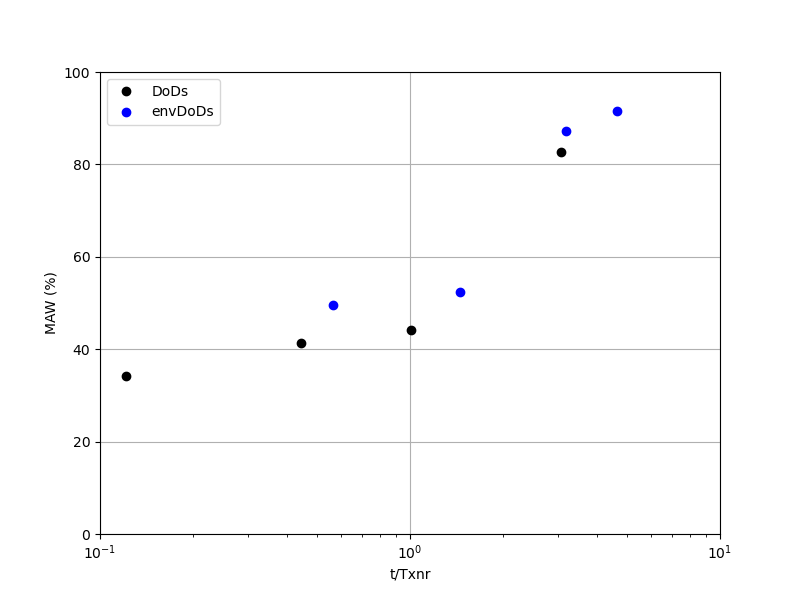

In [37]:
t_Txnr_sums = df_surveys['sum_t_Txnr_above_Qc'].to_numpy()[1:5]
t_Txnr_sums_env = df_surveys['sum_t_Txnr_above_Qc'].to_numpy()[[6,8,10,12]]
# plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(t_Txnr_sums, MAW_list, 'ko', label = 'DoDs')
ax1.plot(t_Txnr_sums_env, envMAW_list, 'bo', label = 'envDoDs')
ax1.set_xscale('log')
ax1.set_xlim(0.1,10)
ax1.set_ylim(0,100)
ax1.set_ylabel('MAW (%)')
ax1.legend()
ax1.set_xlabel('t/Txnr')
plt.grid('on')

## Overview of the MAW vs t_Txnr

In [55]:
# Get the data
MAW_Pinz = np.concatenate((MAW_list, envMAW_list))
MAW_Pinz = np.array(MAW_Pinz)/100
t_Txnr_Pinz = np.concatenate((t_Txnr_sums, t_Txnr_sums_env))
adim_stream_DoD = df_surveys['mean_w*_above_Qc [m]'].to_numpy()[1:5]
adim_stream_envDoD = df_surveys['mean_w*_above_Qc [m]'].to_numpy()[[6,8,10,12]]
adim_stream_Pinz = np.concatenate((adim_stream_DoD, adim_stream_envDoD))

# Sunwapta data
MAW_Sunwapta = np.array([21.8,21.76,40.5])/100#[0,0,1.18,2.54,3.89,21.8,21.76,4.62,1.58,0,40.5]
t_Txnr_Sunwapta = [0.31,0.41,2.43] #[0.05,0.24,0.3,0.26,0.26,0.31,0.41,0.26,0.15,0.21,2.43]
adim_stream_Sunwapta = [0.057,0.057,0.057]#,0.057,0.057,0.057,0.057,0.057,0.057,0.057,0.057]

# Rees data
MAW_rees = np.array([40.78728631, 51.49560313, 19.13942802, 18.01031929, 26.90099481, 37.21619585, 48.5941221,  76.45234544])/100
t_Txnr_rees = [0.21962617, 1.65549746, 0.15863156, 0.04403055, 0.19174556, 0.29945668, 0.81586255, 3.38485053]
adim_stream_rees = [0.14748566, 0.14878312, 0.13468163, 0.16448093, 0.18102607, 0.1816052, 0.17730891, 0.16219593]   

# Lab data
MAW_PiQs = np.array([23.6, 36.65, 43.03, 51.65, 69.6, 25.3, 37.075, 44.5, 49.8, 68.2, 36.3, 51.925, 59.6, 64.7, 75, 49.2, 66.05, 74.3, 79.5, 91.1 ])/100
t_Txnr_PiQs= [0.8, 1.6, 2.4, 3.2, 7.2, 0.5, 1, 1.5, 2, 4.5,0.4, 0.8, 1.2, 1.6, 3.6 ,0.5, 1, 1.5, 2, 4.5]
adim_stream_PiQs = [0.07,0.07,0.07,0.07,0.07, 0.11,0.11,0.11,0.11,0.11, 0.14,0.14,0.14,0.14,0.14, 0.25, 0.25, 0.25, 0.25, 0.25]


In [52]:
def power_law_regression(X, Y):
    """
    Fits a power-law relationship (Y = a * X^b) between two series of values using linear regression
    on the log-transformed data, handling NaN values and ensuring the output has the same length as the input.
    
    Parameters:
    X (list or numpy array): Independent variable data
    Y (list or numpy array): Dependent variable data
    
    Returns:
    a (float): Coefficient of the power law
    b (float): Exponent of the power law
    Y_pred (numpy array): Predicted Y values based on the power law relationship,
                          with NaN values at the same positions as in the original input.
    """
    
    # Convert inputs to numpy arrays (if they aren't already)
    X = np.array(X)
    Y = np.array(Y)
    
    # Create a mask to filter out NaN values from both X and Y
    valid_mask = ~np.isnan(X) & ~np.isnan(Y)
    
    # Filter out NaN values
    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    
    if len(X_valid) == 0 or len(Y_valid) == 0:
        raise ValueError("No valid data points after removing NaNs.")
    # Take the logarithm of X and Y
    log_X = np.log(X_valid)
    log_Y = np.log(Y_valid)
    
    # Perform linear regression on the log-transformed data
    mean_log_X = np.mean(log_X)
    mean_log_Y = np.mean(log_Y)
    
    # Calculate the slope (b)
    b = np.sum((log_X - mean_log_X) * (log_Y - mean_log_Y)) / np.sum((log_X - mean_log_X) ** 2)
    
    # Calculate the intercept (log(a))
    log_a = mean_log_Y - b * mean_log_X
    
    # Convert log(a) back to a
    a = np.exp(log_a)
    
    # Initialize Y_pred with NaN values and fill in the predictions for valid indices
    Y_pred = np.full_like(X, np.nan)  # Create an array of NaNs with the same shape as X
    Y_pred[valid_mask] = a * X_valid ** b  # Apply the power law relationship to the valid data points
    
    return a, b, Y_pred

In [53]:
# Compute empirical MAW-t_TXnr relationship in function of dimensionless stream power 
x_plot = [0,0.01,0.02,0.05,0.07,0.08,0.1,0.2,0.3,0.4,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5]
a_list = []
b_list = []
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[0:5], MAW_PiQs[0:5]) #q05
a_list.append(a)
b_list.append(b)
PiQs_MAW_q05_pred =  [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[5:10], MAW_PiQs[5:10]) #q07
a_list.append(a)
b_list.append(b)
PiQs_MAW_q07_pred = [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[10:15], MAW_PiQs[10:15]) #q10
a_list.append(a)
b_list.append(b)
PiQs_MAW_q10_pred = [a*x**b for x in x_plot]
a, b, Y_pred = power_law_regression(t_Txnr_PiQs[15:20], MAW_PiQs[15:20]) #q20
a_list.append(a)
b_list.append(b)
PiQs_MAW_q20_pred = [a*x**b for x in x_plot]
print(a,b)

0.6346018011632205 0.277589165299307


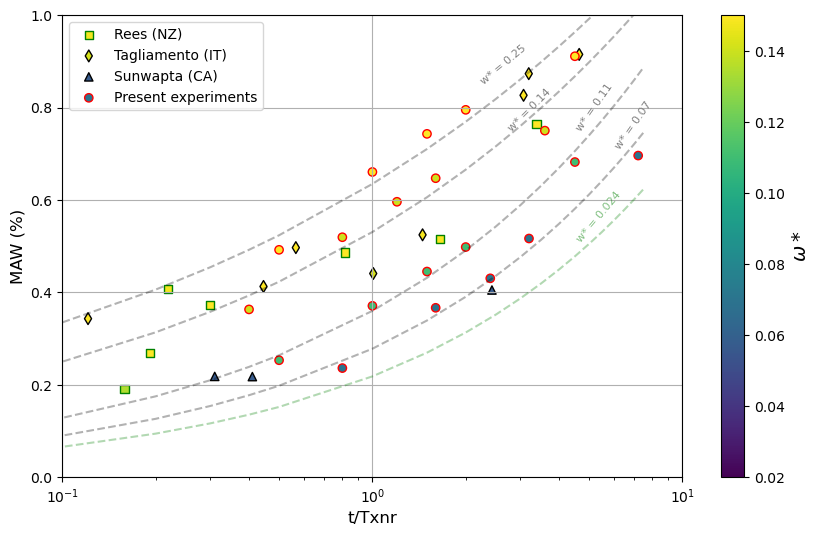

In [81]:
%matplotlib inline
from matplotlib.colors import Normalize
import os

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
# colors
# Step 1: Combine z-values to find global min and max
all_colors = np.concatenate([adim_stream_PiQs, adim_stream_Sunwapta, adim_stream_Pinz])
color_min, color_max = all_colors.min(), all_colors.max()
# Step 2: Normalize z-values using the global min and max
norm = Normalize(vmin=0.02, vmax=0.15)
cmap = 'viridis'

ax1.scatter(t_Txnr_rees, MAW_rees, marker='s', edgecolors='g', linewidth=1, c=norm(adim_stream_rees), cmap=cmap,  vmin=0, vmax=1, label='Rees (NZ)')
ax1.scatter(t_Txnr_Pinz, MAW_Pinz, marker='d', edgecolors='k', linewidth=1, c=norm(adim_stream_Pinz), cmap=cmap,  vmin=0, vmax=1, label='Tagliamento (IT)')
ax1.scatter(t_Txnr_Sunwapta, MAW_Sunwapta, marker='^', edgecolors='k', linewidth=1, c=norm(adim_stream_Sunwapta), alpha=1, cmap=cmap, vmin=0, vmax=1, label='Sunwapta (CA)')
ax1.scatter(t_Txnr_PiQs, MAW_PiQs, marker='o', edgecolors='r', linewidth=1, c=norm(adim_stream_PiQs), cmap=cmap,  vmin=0, vmax=1, alpha=1, label='Present experiments')

ax1.plot(x_plot, PiQs_MAW_q05_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q07_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q10_pred, 'k--', alpha=0.3)
ax1.plot(x_plot, PiQs_MAW_q20_pred, 'k--', alpha=0.3)

# predict the MAW-t/Txnr relationship for w*=0.02
a = 196 * 0.024 + 17.1
b = -1.18 * 0.024 + 0.55
PiQs_MAW_w002_pred = [a * x**b for x in x_plot]
PiQs_MAW_w002_pred = np.array(PiQs_MAW_w002_pred) / 100
ax1.plot(x_plot, PiQs_MAW_w002_pred, 'g--', alpha=0.3)

# Add text to the plot
ax1.text(2.2, 0.85, 'w* = 0.25', fontsize=8, color='gray', rotation=40)
ax1.text(2.7, 0.75, 'w* = 0.14', fontsize=8, color='gray', rotation=45)
ax1.text(4.5, 0.75, 'w* = 0.11', fontsize=8, color='gray', rotation=55)
ax1.text(6, 0.71, 'w* = 0.07', fontsize=8, color='gray', rotation=55)
ax1.text(4.5, 0.51, 'w* = 0.024', fontsize=8, color='g', alpha=0.5, rotation=50)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label(r'$\omega*$', fontsize=14)  # Set font size for omega* label

# Set axis labels with font size
ax1.set_xlabel('t/Txnr', fontsize=12)
ax1.set_ylabel('MAW (%)', fontsize=12)

ax1.set_ylim(0, 1)
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.legend(loc='upper left')
plt.grid('on')

# Save the plot as a PDF
plt.savefig(os.path.join('E:\\repos\\Pi_analysis\\Rivers_analysis\\MAW_rivers_report.png'), format='png', bbox_inches='tight', dpi=800)
plt.savefig(os.path.join('E:\\repos\\Pi_analysis\\Rivers_analysis\\MAW_rivers_report.pdf'), format='pdf', bbox_inches='tight')
plt.show()

---

# Extras

### Create a mask of computational area for all DoDs (not used)

The DoDs have the same dimensions but not the same area where there are values. Also the DoDs have holes where there is vegetation. The mask allow to define the same computation area for all DoDs.

RasterioIOError: e:\repos\Pi_analysis\Rivers_analysis\Tagliamento\pinzano\feb_sep_95ci.tif: No such file or directory

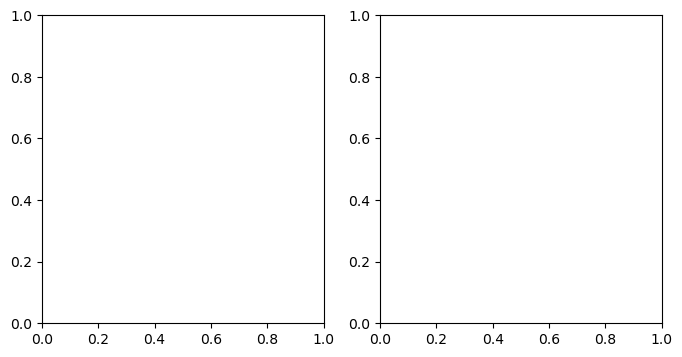

In [42]:
%matplotlib inline
path = os.path.join(home_folder,'pinzano')
DoD_names = ['feb_sep','sep_jan','jan_nov']

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4)) # creating my fig
for i, DoD_name in enumerate(DoD_names):
    filename = f'{DoD_name}_95ci.tif'
    DoD, Nan = read_tif(os.path.join(path,filename))
    #Nan = np.min(DoD)
    #print(f'Nan value is : {Nan}')
    # create the mask
    if i == 0:
        mask = np.copy(DoD)
        mask_cum = np.where(DoD==Nan, 0, 1)
    else:
        mask = np.where(DoD==Nan, 0, 1)
        mask_cum = mask+mask_cum

final_mask = np.where(mask_cum==len(DoD_names),1,0) # 3 = where in all DoDs there is no nan and no areas that are not present in all DoDs.
ax1.imshow(mask_cum, cmap='viridis', vmin=0, vmax=3)
ax1.set_title('Cumulative mask')
ax2.imshow(final_mask, cmap='viridis', vmin=0, vmax=1)
ax2.set_title('Final mask')
plt.tight_layout()
plt.show()

## Compute DoDs

### Transform DEMs

In [36]:
path = os.path.join(home_folder,'pinzano','rasters')
DEMs_names = ['feb','sep','jan','nov','jun']
for i in range(0,len(DEMs_names)):
        filename = f'{DEMs_names[i]}_wbathy.tif'
        DEM, no_data = read_tif(os.path.join(path,filename))
        dy, dx = np.shape(DEM)
        # Create mask
        if i == 0 :
            mask = np.ones((dy, dx))
        
        mask = np.where(DEM==-9999, 0 , mask)

for i in range(0,len(DEMs_names)):
        filename = f'{DEMs_names[i]}_wbathy.tif'
        DEM, no_data = read_tif(os.path.join(path,filename))
        DEM = np.where(mask==1, DEM, -9999)
        output_path = os.path.join(path, filename[:-4] + '_ult.tif')
        numpy_array_to_raster(output_path,
                          DEM,
                          (341320.6549000000231899,5114353.3932999996468425),
                          1,  # Resolution in x-direction
                          1,  # Resolution in y-direction
                          no_data=-9999,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=32633,  # Default to WGS84
                          driver='GTiff')

C:\Users\thoma\anaconda3\envs\riverwatching\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\feb_wbathy_ult.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\sep_wbathy_ult.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\jan_wbathy_ult.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\nov_wbathy_ult.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\jun_wbathy_ult.tif


In [38]:
path = os.path.join(home_folder,'pinzano','rasters')
DEMs_names = ['feb','sep','jan','nov','jun']
for i in range(0,len(DEMs_names)-1):
    filename1 = f'{DEMs_names[i]}_wbathy_ult.tif'
    filename2 = f'{DEMs_names[i+1]}_wbathy_ult.tif'
    DEM1,_ = read_tif(os.path.join(path,filename1))
    DEM2,_ = read_tif(os.path.join(path,filename2))
    nan_mask = np.where(DEM1==-9999,0,1)
    nan_mask = np.where(DEM2==-9999,0,nan_mask)
    DoD_raw = np.where(nan_mask==1,DEM2-DEM1,-9999)
    DoD_thresholded = np.where(np.abs(DoD_raw)<0.1531, -9999, DoD_raw) #/0.29854
    output_path =  os.path.join(path, DEMs_names[i]+'-'+DEMs_names[i+1]+'_DoD_raw.tif')
    # save in tiff format
    numpy_array_to_raster(output_path,
                          DoD_raw,
                          (341320.6549000000231899,5114353.3932999996468425),
                          1,  # Resolution in x-direction
                          1,  # Resolution in y-direction
                          no_data=-9999,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=32633,  # Default to WGS84
                          driver='GTiff')

Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\feb-sep_DoD_raw.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\sep-jan_DoD_raw.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\jan-nov_DoD_raw.tif
Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\nov-jun_DoD_raw.tif


In [38]:
path = os.path.join(home_folder,'pinzano','rasters','DoD_cleaned')
DoD_name = 'sep-jan_DoD_plot_cleaned.tif'
DoD,_ = read_tif(os.path.join(path,DoD_name))
output_path =  os.path.join(path, DoD_name[:-4]+'_utm.tif')
# save in tiff format
numpy_array_to_raster(output_path,
                          DoD,
                          (341320.6549000000231899,5114353.3932999996468425),
                          1,  # Resolution in x-direction
                          1,  # Resolution in y-direction
                          no_data=-9999,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=32633,  # Default to WGS84
                          driver='GTiff')

Array Shape: Rows = 1524, Columns = 1274, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\rasters\DoD_cleaned\sep-jan_DoD_plot_cleaned_utm.tif


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000015E85C9DFC0> >

In [12]:
path = os.path.join(home_folder,'pinzano')
DEMs_names = ['feb','sep','jan','nov','june']
for i in range(0,len(DEMs_names)-1):
    filename = f'{DEMs_names[i]}_{DEMs_names[i+1]}_95ci_ult.tif'
    DoD,_ = read_tif(os.path.join(path,filename))
    DoD = np.abs(DoD)
    print(filename)
    print(str(np.min(DoD[DoD>0])))

feb_sep_95ci_ult.tif
0.29400635
sep_jan_95ci_ult.tif
0.29400635
jan_nov_95ci_ult.tif
0.2940216
nov_june_95ci_ult.tif
0.29400635


# MAW-Txnr-w* relationship
---

In [11]:
path = os.path.join(home_folder,'pinzano')
DoD_names = ['feb_sep','sep_jan','jan_nov']

upper_left_tuple_list = [(341520.3381999999983236,5114200.0714999996125698),(341449.6484000000054948,5114159.3935000002384186),
                         (341398.2754999999888241,5114195.0714999996125698)]

cell_resolutions_list = [[1.160547084708460464,0.9314323577234839835],[1.055401320131987397,0.9322381300813844529],
                          [1.194719471947194744,0.9910569105691057201]]

for i, DoD_name in enumerate(DoD_names):
    filename = f'{DoD_name}_95ci'
    output_path = os.path.join(path, filename +'_ult.tif')
    DoD = read_tif(os.path.join(path,filename+'.tif'))
    DoD=np.where(DoD<-100,-9999,DoD)
    Nan = float(-9999)
    numpy_array_to_raster(output_path,
                          DoD,
                          upper_left_tuple_list[i],
                          1,  # Resolution in x-direction
                          1,  # Resolution in y-direction
                          no_data=Nan,
                          gdal_data_type=gdal.GDT_Float32,
                          spatial_reference_system_wkid=32633,  # Default to WGS84
                          driver='GTiff')

Array Shape: Rows = 1230, Columns = 909, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\feb_sep_95ci_ult.tif
Array Shape: Rows = 1230, Columns = 909, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\sep_jan_95ci_ult.tif
Array Shape: Rows = 1230, Columns = 909, Bands = 1
Raster successfully created at C:\Users\thoma\Documents\Trento\python\Data\Tagliamento\pinzano\jan_nov_95ci_ult.tif
